Forward / backward resolved scattering
=========================================
*01/2021: updated to pyGDM v1.1+*

In this example, we try to reproduce the directional visible light scattering from silicon spheres, reported by *Fu et al.* [1].



[1]: Fu, Y. H. et al.: *Directional visible light scattering by silicon nanoparticles*. **Nat Commun** 4, 1527 (2013) (https://doi.org/10.1038/ncomms2538)


In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt

Setting up the simulation
--------------------------------

In [2]:
## --- Setup incident field
field_generator = fields.planewave
wavelengths = np.exp(np.linspace(np.log(300), np.log(1000), 30))
kwargs = dict(theta = [0.0])
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## --- Setup geometry (sphere D=150nm in vacuum)
scale_factor = 1.4
step = 18.75/scale_factor
radius = 4.*scale_factor
geometry = structures.sphere(step, R=radius, mesh='hex', ORIENTATION=2)
material = materials.silicon()
struct = structures.struct(step, geometry, material)

dyads = propagators.DyadsQuasistatic123(n1=1, n2=1)

sim = core.simulation(struct, efield, dyads)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 1159/1159 dipoles valid


Run the simulation, get FW/BW scattering spectra
-------------------------------------------------

At first we run the main simulation *core.scatter*, then we calculate the scattering to the farfield separately for the upper and lower hemi-sphere:

In [3]:
## main simulation
E = core.scatter(sim, method='lu', verbose=True)

## FW and BW scattering spectrum
field_kwargs = tools.get_possible_field_params_spectra(sim)[0]
wl, scat_fw = tools.calculate_spectrum(sim, field_kwargs, linear.farfield, 
                                      tetamin=np.pi/2., tetamax=np.pi, 
                                      return_value='int_Es')
wl, scat_bw = tools.calculate_spectrum(sim, field_kwargs, linear.farfield, 
                                      tetamin=0, tetamax=np.pi/2., 
                                      return_value='int_Es')

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=300.00nm - setup: EE 7740.3ms, inv.: 4652.8ms, repropa.: 2363.3ms (1 field configs), tot: 14756.9ms
timing for wl=312.72nm - setup: EE 737.4ms, inv.: 1884.7ms, repropa.: 13.5ms (1 field configs), tot: 2636.4ms
timing for wl=325.97nm - setup: EE 261.1ms, inv.: 1791.0ms, repropa.: 13.4ms (1 field configs), tot: 2069.3ms
timing for wl=339.79nm - setup: EE 221.0ms, inv.: 1662.2ms, repropa.: 13.4ms (1 field configs), tot: 1897.6ms
timing for wl=354.20nm - setup: EE 268.1ms, inv.: 1899.1ms, repropa.: 13.8ms (1 field configs), tot: 2182.0ms
timing for wl=369.21nm - setup: EE 234.2ms, inv.: 3208.1ms, repropa.: 25.6ms (1 field configs), tot: 3469.7ms
timing for wl=384.86nm - setup: EE 659.2ms, inv.: 4652.4ms, repropa.: 27.2ms (1 field configs), tot: 5340.3ms
timing for wl=401.17nm - setup: EE 767.4ms, inv.: 4333.1ms, repropa.: 34.7ms (1 field configs), tot: 5136.6ms
timing for wl=418.18nm - setup: EE 761.8ms, inv.: 3195.4ms, repropa.: 13.9ms (1 field configs), tot: 3972.0ms
timing

Plot the FW/BW spectra
---------------------------

Let's see what scattering we get in both directions:

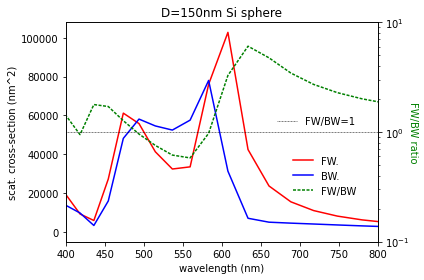

In [4]:
plt.figure()
plt.title(r"D=150nm Si sphere")

## --- scattering spectra FW & BW
plt.plot(wl, scat_fw, 'r', label='FW.')
plt.plot(wl, scat_bw, 'b', label='BW.')

plt.xlabel("wavelength (nm)")
plt.ylabel(r"scat. cross-section (nm^2)")
plt.xlim(400,800)

plt.plot([0], [0], color='g', dashes=[2,1], label='FW/BW')  # for legend entry
plt.legend(loc='center', frameon=False, ncol=1, bbox_to_anchor=(0.83, 0.3))


## --- logscale FW/BW ratio on right y-axis
plt.twinx()
plt.plot(wl, scat_fw/scat_bw, color='g', dashes=[2,1])
plt.plot([400,800], [1,1], color='k', lw=0.5, dashes=[2,1], label='FW/BW=1')

plt.ylabel(r"FW/BW ratio", rotation=270, labelpad=8, color='g')
plt.yscale('log')
plt.xlim( [400, 800] )
plt.ylim( [0.1, 10] )
plt.legend(loc='center', frameon=False, ncol=1, bbox_to_anchor=(0.8, 0.55))


plt.tight_layout()
plt.show()

Comparing this with the paper [1], cited at the very top, this looks pretty much exactly like their results (let's say like a pixelated version of it...).